In [1]:
# importing libraries
import numpy as np  
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [21]:
# defining the helper functions
# case = 1
# X = np.array([ [1, 8], [3, 8], [5, 1], [-6, -1], [7, 3], [8, 7]])
# y = np.array([-1, 1, 1, -1, 1, -1])

case = 4
X = np.array([
    [27.65, 15.65],
    [23.1 , 14.6 ],
    [23.5 , 15.2 ],
    [24.05, 14.9 ],
    [24.5 , 14.7 ],
    [14.15, 17.35],
    [14.3 , 16.8 ],
    [14.3 , 15.75],
    [14.75, 15.1 ],
    [15.35, 15.5 ]
])

y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])

initial_idx = 0
x1_p =  max(X[initial_idx][0],0)
x1_n = abs(min(X[initial_idx][0],0))
x2_p = max(X[initial_idx][1],0)
x2_n = abs(min(X[initial_idx][1],0))
y1_p = max(y[initial_idx],0)
y1_n = abs(min(y[initial_idx],0))

threshold = 1e-8
d = 10**(-10)
lr = 0.0001
ct = 1/500

freq = 425
e=500
num =len(X)


In [3]:
# oscillator wrapper function takes in an array of oscillating species names, array of doped species, current timestep

def oscillator_function(y,t,num_oscillating_species):
    # making the array of the oscillating species
    oscillating_species = y[0:num_oscillating_species]
    doped_species = y[num_oscillating_species:]

    num_doped_species = len(doped_species)

    # initialisinng the derivatives
    d_oscillating_species = np.zeros(num_oscillating_species)
    d_doped_species = np.zeros(num_doped_species)

    # defining the derivatives 

    # for the oscillating species
    d_oscillating_species[0] = -oscillating_species[0]*oscillating_species[1] + oscillating_species[num_oscillating_species-1]*oscillating_species[0] + doped_species[0]*oscillating_species[num_oscillating_species-1] - doped_species[1]*oscillating_species[0]

    for idx in range(1,num_oscillating_species-1):
        d_oscillating_species[idx] = oscillating_species[idx-1]*oscillating_species[idx] - oscillating_species[idx+1]*oscillating_species[idx] + doped_species[idx]*oscillating_species[idx-1] - doped_species[idx+1]*oscillating_species[idx]
    
    d_oscillating_species[num_oscillating_species-1] = oscillating_species[num_oscillating_species-2]*oscillating_species[num_oscillating_species-1] - oscillating_species[0]*oscillating_species[num_oscillating_species-1] + doped_species[num_doped_species-1]*oscillating_species[num_oscillating_species-2] - doped_species[0]*oscillating_species[num_oscillating_species-1]

    # for the doped species
    d_doped_species[0] = -doped_species[0]*oscillating_species[num_doped_species-1]

    for idx in range(1,num_doped_species):
        d_doped_species[idx] = -doped_species[idx]*oscillating_species[idx-1]
    
    dydt = []
    dydt.extend(d_oscillating_species)
    dydt.extend(d_doped_species)
    
    return dydt

def oscillator_wrapper(oscillating_species, doped_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    # making an array of the species concentrations at timestep: current_timestep - 1
    oscillating_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in oscillating_species])
    doped_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in doped_species])

    # number of oscillating species 
    num_oscillating_species = len(oscillating_species_concentrations)

    # making the input array for the oscillator function
    y_0 = []
    y_0.extend(oscillating_species_concentrations)
    y_0.extend(doped_species_concentrations)

    # calculating the time range
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps

    # solving the ODE
    sol = odeint(oscillator_function, y_0, t, args=(num_oscillating_species,))

    # review if you wanna add threshold
    # updating the species concentrations in current timestep
    for idx, species in enumerate(oscillating_species):
        species_concentrations_current_timestep[species] = sol[1][idx]

    for idx, species in enumerate(doped_species):
        species_concentrations_current_timestep[species] = sol[1][num_oscillating_species + idx]

    return species_concentrations_current_timestep

In [4]:
# laoding function
def load_function(y,t,a, o):
    c = y[0]
    dc_dt = -c*o + a*o
    return [ dc_dt]

def load_wrapper(from_species, to_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    from_species_concentration = species_concentrations[from_species][current_timestep - 1]
    to_species_concentration = species_concentrations[to_species][current_timestep - 1]
    regulating_species_concentration = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [to_species_concentration]
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps
    
    sol = odeint(load_function, y0, t, args=(from_species_concentration, regulating_species_concentration))

    # threshold_loading = 1e-4


    if np.abs(sol[1][0] - to_species_concentration) > threshold: # to ensure update only happens when substantial #review
        species_concentrations_current_timestep[to_species] = sol[1][0] # only value of to_species is updated

    return species_concentrations_current_timestep



In [5]:
# multiplication function
def product_f(y,t,multiplicand_species_concentrations,o):
    c = y[0]

    dc_dt = 0

    temp = 1
    for idx, multiplicand in enumerate(multiplicand_species_concentrations):
        temp  = temp * multiplicand
    
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def product_wrapper(multiplicand_species, product,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    multiplicand_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in multiplicand_species])

    c = species_concentrations[product][current_timestep - 1]
    o = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(product_f, y0, t, args=(multiplicand_species_concentrations, o))

    # threshold_product = 1e-4

    if np.abs(c-sol[1][0])> threshold:
        species_concentrations_current_timestep[product] = sol[1][0]
      
    return species_concentrations_current_timestep

In [6]:
# sum function
def sum_f(y,t,additive_species_concentrations,o):
    c = y[0]
    temp =0
    for idx, additive in enumerate(additive_species_concentrations):
        temp = temp + additive
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def sum_wrapper(additive_species, sum, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep -1
    additive_species_concentrations =  np.array([species_concentrations[species][current_timestep - 1] for species in additive_species])

    c = species_concentrations[sum][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(sum_f, y0, t, args=(additive_species_concentrations,o))

    # threshold_sum = 1e-4

    if np.abs(c-sol[1][0]) > threshold:
        species_concentrations_current_timestep[sum] = sol[1][0]

    return species_concentrations_current_timestep

In [7]:
# mapping function for comparison
def comparison_f(y, t, a, b, o):
    dydt = []
    bgta = y[0]
    blta = y[1]

    temp = b*blta*o - bgta*a*o
    dydt.append(temp)

    temp = bgta*a*o - b*blta*o
    dydt.append(temp)

    return dydt

def comparison_wrapper(species_a,species_b, b_gt_a, b_lt_a, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep):

    a = species_concentrations[species_a][current_timestep-1]
    b = species_concentrations[species_b][current_timestep-1]
    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [bgta, blta]
    t = np.linspace(current_timestep -1, current_timestep, 2)
    
    sol = odeint(comparison_f, y0, t, args=(a,b, o))

    # threshold_comparison = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]

    return species_concentrations_current_timestep


In [8]:
# approximate majority for comparison
def approx_majority_f(y, t, o):
    kgtq = y[0]
    kltq = y[1]
    b_help = y[2]

    dydt = []
    
    temp =  - kgtq*kltq*o + kgtq *b_help*o
    dydt.append(temp)

    temp = kltq*b_help*o - kgtq*kltq*o
    dydt.append(temp)

    temp = 2* kgtq*kltq*o - kgtq*b_help*o - kltq*b_help*o
    dydt.append(temp)

    return dydt

def approx_majority_wrapper(b_gt_a, b_lt_a, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    helper_s = species_concentrations[helper_species][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y_0 = [bgta, blta, helper_s]

    t = np.linspace(current_timestep, current_timestep+1, 2)

    sol = odeint(approx_majority_f, y_0, t, args=(o,))

    # threshold_am = 1e-4

    if np.abs(bgta-sol[:,0][-1]) > threshold:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]
    if np.abs(helper_s - sol[:,2][-1]) > threshold:
        species_concentrations_current_timestep[helper_species] = sol[:,2][-1]

    return species_concentrations_current_timestep


In [9]:
# w_x = w*x module

# takes in arrays containing strings of the name of the species 
def product_wx(weights_array, x_array, product_array, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    num_indices = len(weights_array)
    for i in range(num_indices):
        species_concentrations_current_timestep = product_wrapper([weights_array[i] , x_array[i]] , product_array[i] , regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
    return species_concentrations_current_timestep


In [10]:
# summation of species

# takes in arrays containing strings of name of species
def summation_wx_b(additive_array, sum_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = sum_wrapper(additive_array, sum_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep
    

In [11]:
# Q = YP

def yp(yp, y,p,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    for i in range(4):
        species_concentrations_current_timestep = product_wrapper([y[i],p[i]], yp[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)


    return species_concentrations_current_timestep


In [12]:
# Q+ & Q- . q[0] is for Q+ and q[1] is for Q- + K ( K is 1 here)

def q(q, yp, K ,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = sum_wrapper([yp[0],yp[1]], q[0], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = sum_wrapper([yp[2],yp[3],K], q[1], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [13]:
#  comparing Q+ and Q- +1. we are really comparing Q+ and (Q- + K) where K is 1. if qgtk > qltk Q+ > Q- +1. if qgtk < qltk Q+ < Q- +1
def comparing_q(q, qgtk, qltk, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    species_concentrations_current_timestep = comparison_wrapper(q[1],q[0], qgtk, qltk, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep

In [14]:
# applying approximate majority

def q_am(qgtk, qltk, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    species_concentrations_current_timestep = approx_majority_wrapper(qgtk, qltk, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

    return species_concentrations_current_timestep


In [15]:
def calculate_update_weights(weights, x_array, y_array, cost_always, cost_classification_1, cost_classification_2,  regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    lr = 'lr'
    const_temp  = 'ct'
    l = len(weights)

    for i in range(l):
        species_concentrations_current_timestep = product_wrapper([lr, const_temp, weights[int((len(weights) /2  + i )%len(weights))]], cost_always[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper([lr, x_array[i], 'Q_lt_K', y_array[0] ], cost_classification_1[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
        species_concentrations_current_timestep = product_wrapper([lr, x_array[int((len(x_array) /2  + i )%len(x_array))], 'Q_lt_K', y_array[1] ], cost_classification_2[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)

        
    return species_concentrations_current_timestep

In [16]:
def update_weights(weights, final_weights , cost_always, cost_classification_1, cost_classification_2, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    l = len(weights)

    for i in range(l):
        species_concentrations_current_timestep = sum_wrapper([weights[i], cost_always[i], cost_classification_1[i] , cost_classification_2[i]], final_weights[i], regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep)
        
    return species_concentrations_current_timestep

In [17]:
# defining the species concentrations dictionary



species_concentrations = {
    # oscillating species
    'o1' : [1],
    'o2' : [0],
    'o3' : [0],
    'o4' : [0],
    'o5' : [0],
    'o6' : [0],
    'o7' : [0],
    'o8' : [0],
    'o9' : [0], 
    'o10' : [0],
    'o11' : [0],
    'o12' : [0],
    'o13' : [0],
    'o14' : [0],
    'o15' : [0],
    'o16' : [0],
    'o17' : [0],
    'o18' : [0],

    # doped species
    'd1' : [d],
    'd2' : [d],
    'd3' : [d],
    'd4' : [d],
    'd5' : [d],
    'd6' : [d],
    'd7' : [d],
    'd8' : [d],
    'd9' : [d],
    'd10' : [d],
    'd11' : [d],
    'd12' : [d],
    'd13' : [d],
    'd14' : [d],
    'd15' : [d],
    'd16' : [d],
    'd17' : [d],
    'd18' : [d],
    

    # input species
    'x1_p': [x1_p], # x1 is 2
    'x2_p': [x2_p], # x2 is 1
    # 'x3_p': [5], # x3 is 5
    'x1_n': [x1_n],
    'x2_n': [x2_n],
    # 'x3_n': [0],

    # weight species
    'w1_p': [1], # w1 is 5
    'w2_p': [1], # w2 is 1
    # 'w3_p': [0], # w3 is -8
    'w1_n': [0],
    'w2_n': [0],
    # 'w3_n': [8],
    
    # product species
    'w1px1p_p': [0],
    'w2px2p_p': [0],
    # 'w3px3p_p': [0],
    'w1nx1n_p': [0],
    'w2nx2n_p': [0],
    # 'w3nx3n_p': [0],
    'w1px1n_n': [0],
    'w2px2n_n': [0],
    # 'w3px3n_n': [0],
    'w1nx1p_n': [0],
    'w2nx2p_n': [0],
    # 'w3nx3p_n': [0],

    # bias species
    'b_p': [0],
    'b_n': [0],

    # sum species
    'P_p': [0],
    'P_n': [0],

    # output species
    'y_p': [y1_p],
    'y_n': [y1_n],

    # yp species
    'ypPp_p': [0],
    'ynPn_p': [0],
    'ypPn_n': [0],
    'ynPp_n': [0],

    # Q species
    'Q_p': [0],
    'Q_n+K': [0],

    # K species
    'K': [1], 

    # qgtk, qltk & helper species
    'Q_gt_K': [0.5],
    'Q_lt_K': [0.5],
    'helper': [0],

    # lr and ct
    'lr': [lr],
    'ct': [ct],

    # cost always species : lr*ct* species
    'lr_ct_w1_n': [0],
    'lr_ct_w2_n': [0],
    # 'lr_ct_w3_n': [0],
    'lr_ct_w1_p': [0],
    'lr_ct_w2_p': [0],
    # 'lr_ct_w3_p': [0],

    # cost classification 1 species : lr*species*Q_gt_K* y_p
    'lr_Q_lt_K_y_p_x1_p': [0],
    'lr_Q_lt_K_y_p_x2_p': [0],
    # 'lr_Q_gt_K_y_p_x3_p': [0],
    'lr_Q_lt_K_y_p_x1_n': [0],
    'lr_Q_lt_K_y_p_x2_n': [0],
    # 'lr_Q_gt_K_y_p_x3_n': [0],


    # cost classification 2 species : lr*species_complement*Q_gt_K* y_n
    'lr_Q_lt_K_y_n_x1_n': [0],
    'lr_Q_lt_K_y_n_x2_n': [0],
    # 'lr_Q_gt_K_y_n_x3_n': [0],
    'lr_Q_lt_K_y_n_x1_p': [0],
    'lr_Q_lt_K_y_n_x2_p': [0],
    # 'lr_Q_gt_K_y_n_x3_p': [0],

    # cost of bias update
    'lr_yn_Q_lt_K': [0],
    'lr_yp_Q_lt_K': [0],

    # final weights
    'w1_p_final': [0],
    'w2_p_final': [0],
    # 'w3_p_final': [0],
    'w1_n_final': [0],
    'w2_n_final': [0],
    # 'w3_n_final': [0],

    # final bias
    'b_p_final': [0],
    'b_n_final': [0],
      

}



In [18]:
# defining the species list
oscillating_species = [
    'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'o9', 'o10' , 'o11', 'o12', 'o13', 'o14', 'o15', 'o16', 'o17' , 'o18'
]

doped_species = [
    'd1', 'd2', 'd3', 'd4', 'd5', 'd6' , 'd7', 'd8', 'd9', 'd10' , 'd11' , 'd12', 'd13', 'd14', 'd15', 'd16', 'd17' , 'd18'                                               
]

weights_array = [
    'w1_p', 'w2_p',  'w1_n', 'w2_n', 
    # 'w1_p', 'w2_p', 'w3_p', 'w1_n', 'w2_n', 'w3_n'
]

x_array = [
    'x1_p', 'x2_p', 'x1_n', 'x2_n'
]

weights_array_2 = [
    'w1_p', 'w2_p', 'w1_n', 'w2_n' , 'w1_p', 'w2_p', 'w1_n', 'w2_n'
]

x_array_2 = [
    'x1_p', 'x2_p', 'x1_n', 'x2_n', 'x1_n', 'x2_n',  'x1_p', 'x2_p'
]

product_array = [
    'w1px1p_p', 'w2px2p_p', 'w1nx1n_p', 'w2nx2n_p', 'w1px1n_n', 'w2px2n_n', 'w1nx1p_n', 'w2nx2p_n'
]

additive_array_p = [
    'w1px1p_p', 'w2px2p_p', 'w1nx1n_p', 'w2nx2n_p', 'b_p'
]

additive_array_n = [
    'w1px1n_n', 'w2px2n_n', 'w1nx1p_n', 'w2nx2p_n', 'b_n'
]

yp_array = [
    'ypPp_p', 'ynPn_p', 'ypPn_n', 'ynPp_n'
]

p_array = [
    'P_p', 'P_n' , 'P_n', 'P_p'
]

y_array = [
    'y_p', 'y_n'
]

y_array_2 = [
    'y_p', 'y_n', 'y_p', 'y_n'
]

q_array = [
    'Q_p', 'Q_n+K'
]

cost_always = [
    'lr_ct_w1_n', 'lr_ct_w2_n', 'lr_ct_w1_p', 'lr_ct_w2_p'
]

cost_classification_1 = [
    'lr_Q_lt_K_y_p_x1_p', 'lr_Q_lt_K_y_p_x2_p', 'lr_Q_lt_K_y_p_x1_n', 'lr_Q_lt_K_y_p_x2_n'
]


cost_classification_2 = [
    'lr_Q_lt_K_y_n_x1_n', 'lr_Q_lt_K_y_n_x2_n', 'lr_Q_lt_K_y_n_x1_p', 'lr_Q_lt_K_y_n_x2_p'
]

final_weights = [
    'w1_p_final', 'w2_p_final', 'w1_n_final', 'w2_n_final', 
]

final_bias = [
    'b_p_final', 'b_n_final'
]




In [19]:


# t_limit  = freq*len(X)*50
t_limit = freq*num*e

idx = 0
# t_limit = 500
for  t in range(1,t_limit):

    # removing loading module
    species_concentrations_current_timestep = {}

    


    # predict 

    # oscillate
    species_concentrations_current_timestep = oscillator_wrapper(oscillating_species, doped_species, t, species_concentrations, species_concentrations_current_timestep)

    if t%freq == 0 and t != 0 :
        idx = (idx+1)%num
        x1_p =  max(X[idx][0],0)
        x1_n = abs(min(X[idx][0],0))
        x2_p = max(X[idx][1],0)
        x2_n = abs(min(X[idx][1],0))
        y1_p = max(y[idx],0)
        y1_n = abs(min(y[idx],0))

        clear_out = 0
        
        species_concentrations_current_timestep['x1_p'] = x1_p
        species_concentrations_current_timestep['x1_n'] = x1_n
        species_concentrations_current_timestep['x2_p'] = x2_p
        species_concentrations_current_timestep['x2_n'] = x2_n
        species_concentrations_current_timestep['y_p'] = y1_p
        species_concentrations_current_timestep['y_n'] = y1_n

        print(f"timestep: {t/t_limit}", x1_p, x1_n, x2_p, x2_n, y1_p, y1_n, end = '\r')

        


    # product wx
    species_concentrations_current_timestep = product_wx(weights_array_2, x_array_2, product_array, 'o1', t, species_concentrations, species_concentrations_current_timestep)

    # sum wx + b = p
    species_concentrations_current_timestep = summation_wx_b(additive_array_p, 'P_p', 'o3', t, species_concentrations, species_concentrations_current_timestep)
    species_concentrations_current_timestep = summation_wx_b(additive_array_n, 'P_n', 'o3', t, species_concentrations, species_concentrations_current_timestep)

    # yp
    species_concentrations_current_timestep = yp(yp_array, y_array_2, p_array, 'o5', t, species_concentrations, species_concentrations_current_timestep)

    # Q 
    species_concentrations_current_timestep = q(q_array, yp_array, 'K', 'o7', t, species_concentrations, species_concentrations_current_timestep)

    # Q+ - Q- > 1
    # comparing Q+ and Q- +1
    species_concentrations_current_timestep = comparing_q(q_array, 'Q_gt_K', 'Q_lt_K', 'o9', t, species_concentrations, species_concentrations_current_timestep)

    # applying approximate majority
    species_concentrations_current_timestep = q_am('Q_gt_K', 'Q_lt_K', 'helper', 'o11', t, species_concentrations, species_concentrations_current_timestep)

    # calculating the update weights
    species_concentrations_current_timestep = calculate_update_weights(weights_array, x_array, y_array, cost_always, cost_classification_1, cost_classification_2, 'o13', t, species_concentrations, species_concentrations_current_timestep)

    # # calculating the update bias 
    # species_concentrations_current_timestep = product_wrapper(['lr', 'y_n', 'Q_gt_K'], 'lr_yn_Q_gt_K', 'o13', t, species_concentrations, species_concentrations_current_timestep)
    # species_concentrations_current_timestep = product_wrapper(['lr', 'y_p', 'Q_gt_K'], 'lr_yp_Q_gt_K', 'o13', t, species_concentrations, species_concentrations_current_timestep)

    # updating the weights concentrations
    species_concentrations_current_timestep = update_weights(weights_array, final_weights , cost_always, cost_classification_1, cost_classification_2, 'o15', t, species_concentrations, species_concentrations_current_timestep)

    # # updating the bias concentrations
    # species_concentrations_current_timestep = sum_wrapper(['lr_yn_Q_gt_K', 'b_p' ], 'b_p_final', 'o15', t, species_concentrations, species_concentrations_current_timestep)
    # species_concentrations_current_timestep = sum_wrapper(['lr_yp_Q_gt_K', 'b_n' ], 'b_n_final', 'o15', t, species_concentrations, species_concentrations_current_timestep)

    # loading to weights
    for i in range(len(final_weights)):
        species_concentrations_current_timestep = load_wrapper(final_weights[i], weights_array[i], 'o17', t, species_concentrations, species_concentrations_current_timestep)
    
    # loading to bias
    # species_concentrations_current_timestep = load_wrapper('b_p_final', 'b_p', 'o17', t, species_concentrations, species_concentrations_current_timestep)
    # species_concentrations_current_timestep = load_wrapper('b_n_final', 'b_n', 'o17', t, species_concentrations, species_concentrations_current_timestep)
    




  
    for species in species_concentrations:
        if species in species_concentrations_current_timestep:
            species_concentrations[species].append(species_concentrations_current_timestep[species])
        else:
            species_concentrations[species].append(species_concentrations[species][t-1])

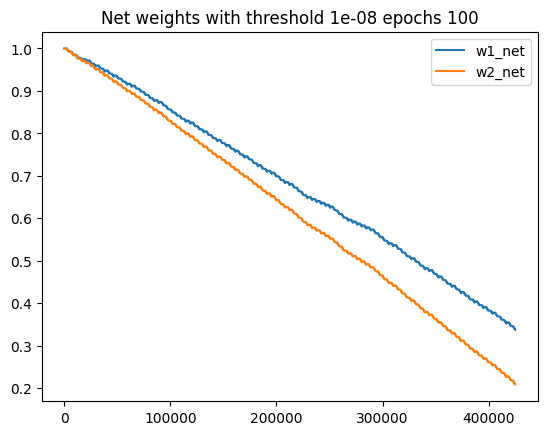

0.3370449362897585 0.20817275279620362 0
100


In [20]:
def net_calc(list1, list2):
    result = [a - b for a, b in zip(list1, list2)]

    return result

w1_net = net_calc(species_concentrations['w1_p'], species_concentrations['w1_n'])
w2_net = net_calc(species_concentrations['w2_p'], species_concentrations['w2_n'])
b_net = net_calc(species_concentrations['b_p'], species_concentrations['b_n'])

# plotting the net weights and bias
time = np.linspace(0,t_limit-1,t_limit)

epochs_point = []
count =0
for t in time:
    if t%(freq*num) ==0:
        epochs_point.append(1)
        count += 1
    else:
        epochs_point.append(0)
plt.plot(time, w1_net, label = 'w1_net')
plt.plot(time, w2_net, label = 'w2_net')
# plt.scatter(time, epochs_point, label='epochs', )
# plt.plot(time, b_net, label = 'b_net')
plt.legend()
plt.title('Net weights with threshold ' + str(threshold) + ' epochs ' + str(count))
plt.savefig('C' + str(case) +'_' + str(threshold)+'_'+str(count)+ '.png')
plt.show()
print(w1_net[-1], w2_net[-1], b_net[-1])
print(count)